<a href="https://colab.research.google.com/github/Cmaraist/Probability_Statistics/blob/main/Hahn_Stats_Lab_Linear_Model_Photo_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture #Importing everything needed 
!pip install wandb
!apt-get install poppler-utils
!pip install pdf2image
!pip install flashtorch
import requests
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import torch
import requests
from torchvision import *
from torchvision.models import *
from flashtorch.utils import apply_transforms
import wandb as wb

In [2]:
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))

def plot(x):
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(5, 5)
    plt.show()
    
def get_google_slide(url):
    url_head = "https://docs.google.com/presentation/d/"
    url_body = url.split('/')[5]
    page_id = url.split('.')[-1]
    return url_head + url_body + "/export/pdf?id=" + url_body + "&pageid=" + page_id

def get_slides(url):
    url = get_google_slide(url)
    r = requests.get(url, allow_redirects=True)
    open('file.pdf', 'wb').write(r.content)
    images = convert_from_path('file.pdf', 500)
    return images

def load(image):

    return apply_transforms(image).clone().detach().requires_grad_(True).to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
labels = {int(key):value for (key, value) in requests.get('https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json').json().items()}

model = alexnet(weights='DEFAULT').to(device)
model.eval();

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [8]:
# url = "https://docs.google.com/presentation/d/1yUN5srh-nLR1brb79_4h1guwyZRNhsSLuPkhu_ZRrpc/edit#slide=id.g19b8867b70f_0_176" #Both links of the slideshow I made

In [9]:
url = "https://docs.google.com/presentation/d/1yUN5srh-nLR1brb79_4h1guwyZRNhsSLuPkhu_ZRrpc/edit#slide=id.g19b8867b70f_0_176"

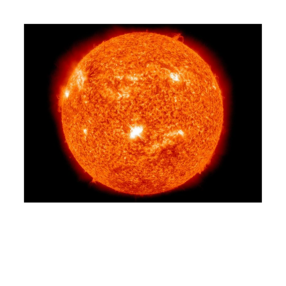

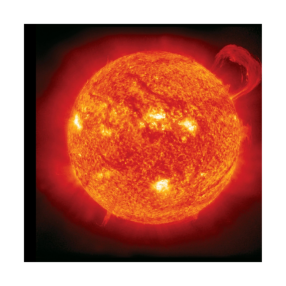

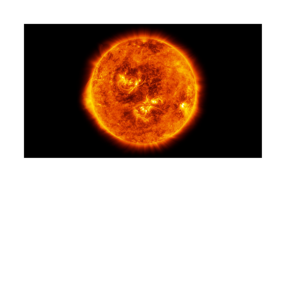

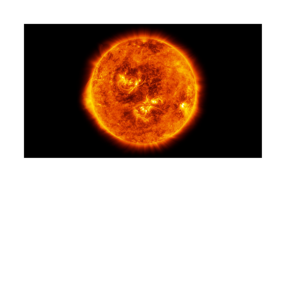

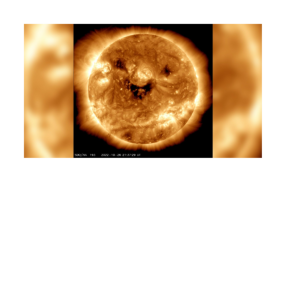

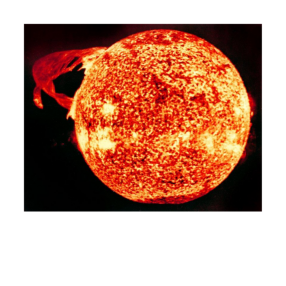

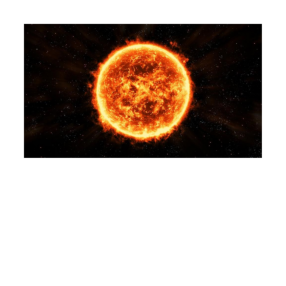

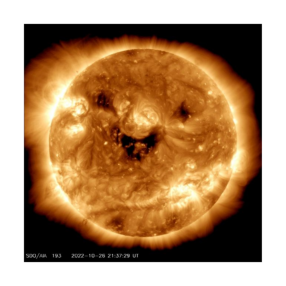

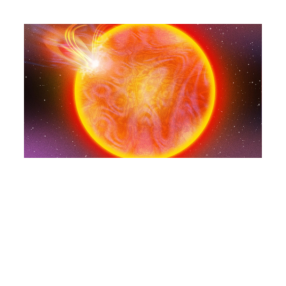

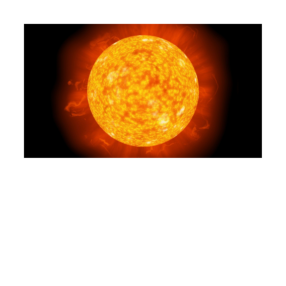

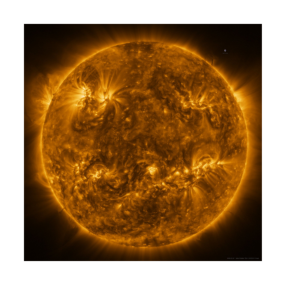

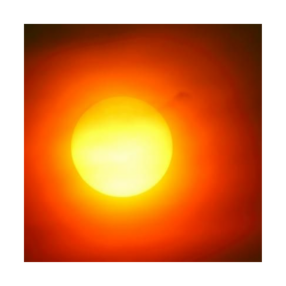

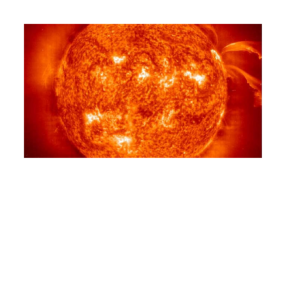

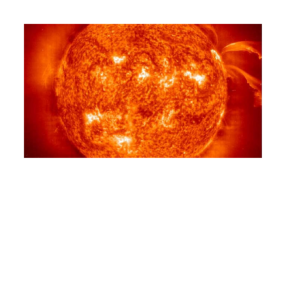

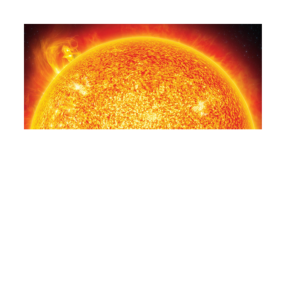

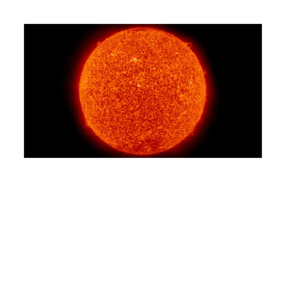

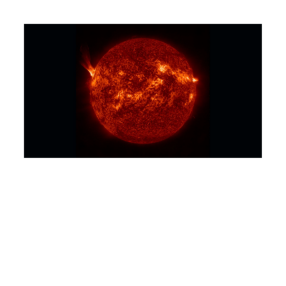

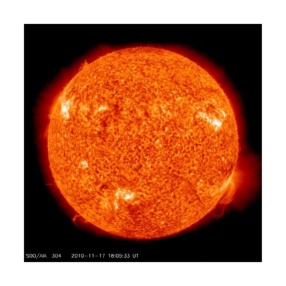

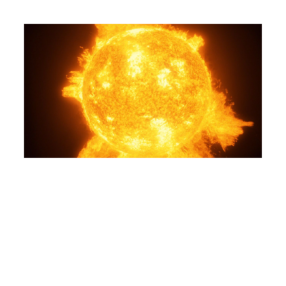

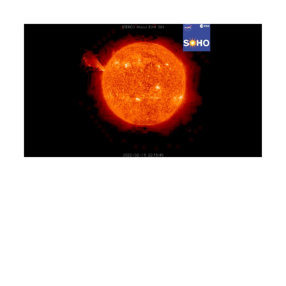

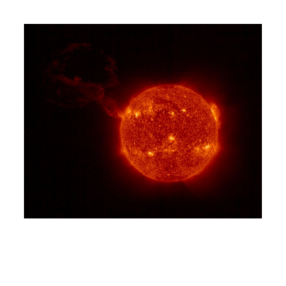

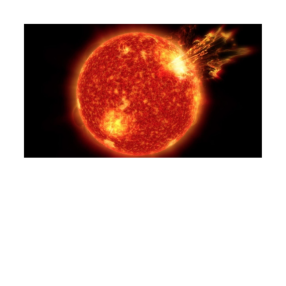

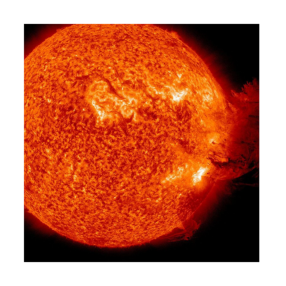

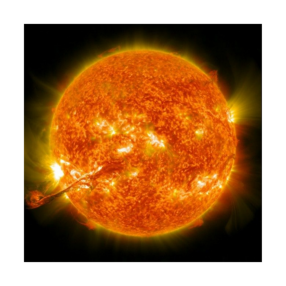

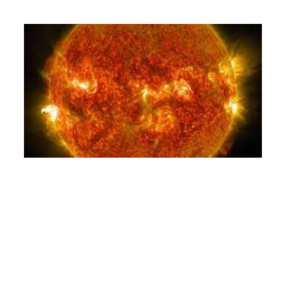

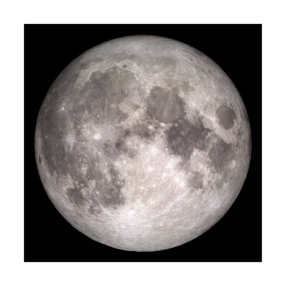

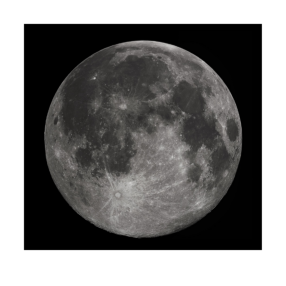

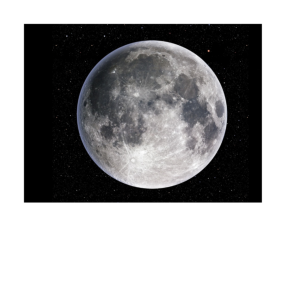

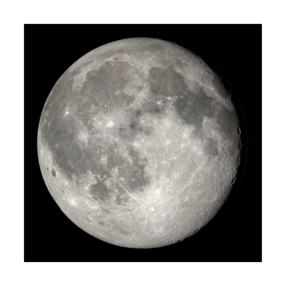

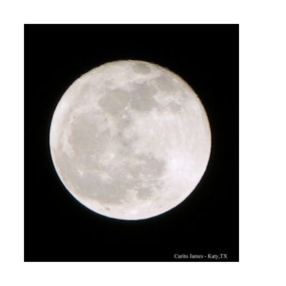

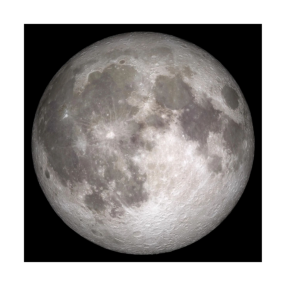

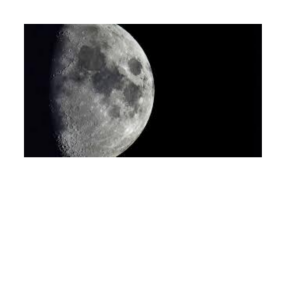

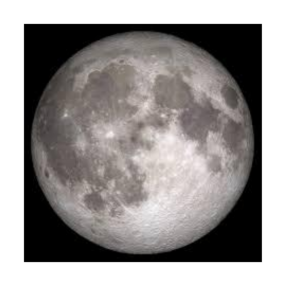

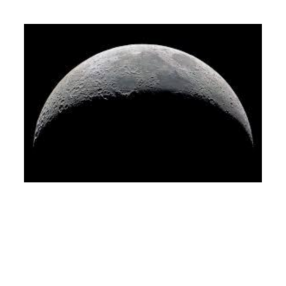

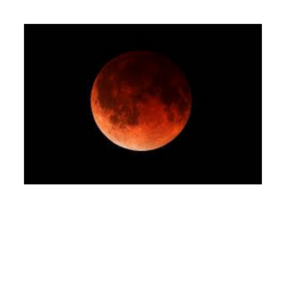

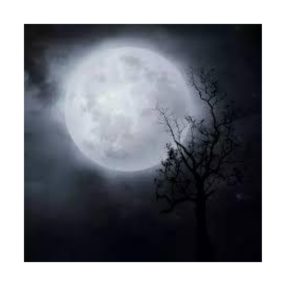

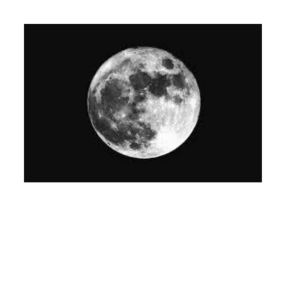

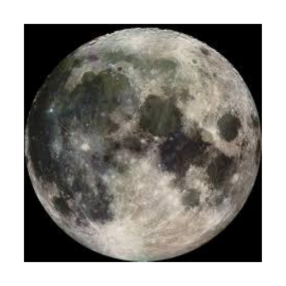

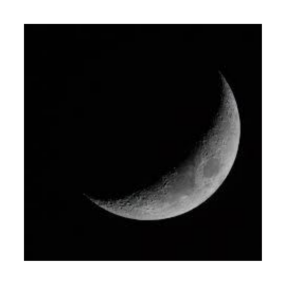

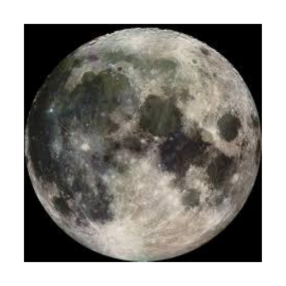

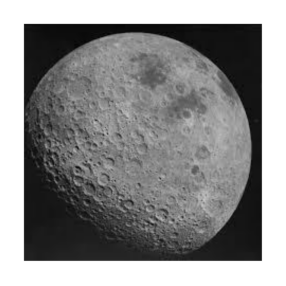

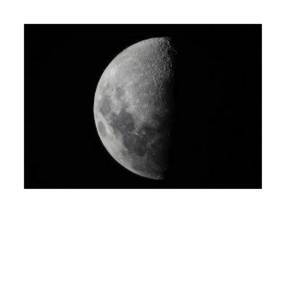

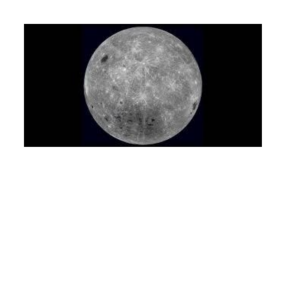

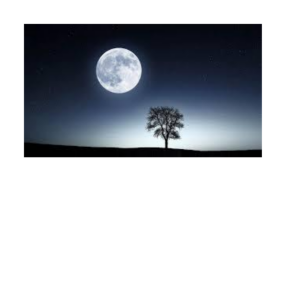

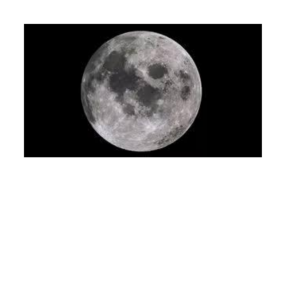

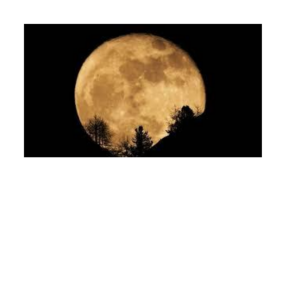

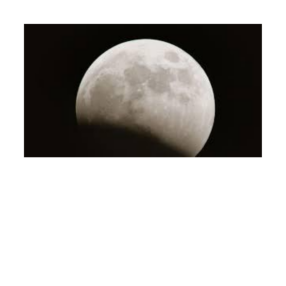

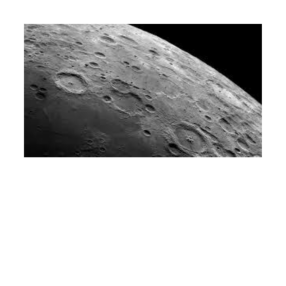

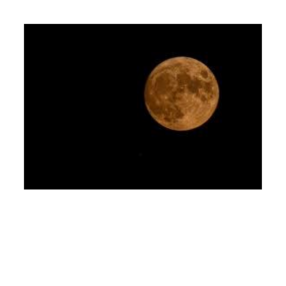

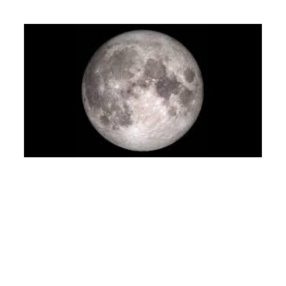

In [11]:
images = []

for image in get_slides(url):

    plot(image)

    images.append(load(image))

images = torch.vstack(images)

In [12]:
images.shape #Making the size of the images

torch.Size([50, 3, 224, 224])

In [13]:
model(images)

tensor([[-2.9805,  4.1887, -6.7342,  ...,  4.2706,  4.6993,  1.1217],
        [ 0.0389,  8.4999, -4.1663,  ...,  2.8689,  4.0101,  0.5912],
        [-3.1524,  2.2742, -6.6958,  ...,  1.3954,  4.3890, -0.3773],
        ...,
        [-1.7456, -4.3488, -0.2558,  ..., -0.5154,  0.7593,  2.8315],
        [-2.5789, -2.6492, -4.9903,  ...,  2.8971,  1.5377,  2.7614],
        [ 0.8870, -1.7740,  0.1332,  ...,  4.3490,  2.7456,  1.9140]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [14]:
y = model(images)

In [16]:
y.shape

torch.Size([50, 1000])

In [17]:
guesses = torch.argmax(y, 1).cpu().numpy()

In [18]:
for i in list(guesses): #How to set up the guesses for what in the pictures, it tries its best but its not alwasy right.
    print(labels[i])

orange
lampshade, lamp shade
orange
orange
toaster
fig
orange
bagel, beigel
pill bottle
orange
gong, tam-tam
candle, taper, wax light
honeycomb
honeycomb
lampshade, lamp shade
orange
traffic light, traffic signal, stoplight
orange
lampshade, lamp shade
traffic light, traffic signal, stoplight
matchstick
matchstick
pick, plectrum, plectron
orange
rotisserie
golf ball
golf ball
Petri dish
golf ball
pick, plectrum, plectron
golf ball
golf ball
golf ball
nematode, nematode worm, roundworm
jellyfish
jellyfish
analog clock
gong, tam-tam
nematode, nematode worm, roundworm
gong, tam-tam
pick, plectrum, plectron
golf ball
golf ball
notebook, notebook computer
golf ball
golf ball
golf ball
nematode, nematode worm, roundworm
analog clock
golf ball


In [19]:
Y = np.zeros(50,)
Y[25:] = 1

In [20]:
X = y.detach().cpu().numpy() 

In [21]:
X.shape

(50, 1000)

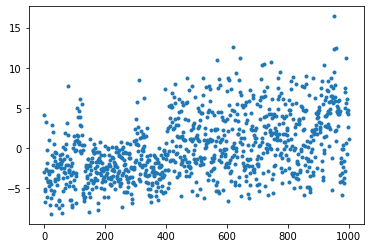

In [22]:
plt.plot(X[0],'.')

(array([ 46., 167., 276., 202., 130., 113.,  52.,  10.,   3.,   1.]),
 array([-8.180607 , -5.7208376, -3.2610683, -0.8012991,  1.6584702,
         4.1182394,  6.5780087,  9.037778 , 11.497547 , 13.957316 ,
        16.417086 ], dtype=float32),
 <a list of 10 Patch objects>)

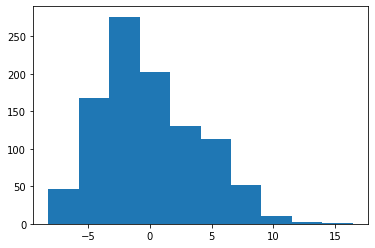

In [23]:
plt.hist(X[0])

In [24]:
X = GPU_data(X)
Y = GPU_data(Y)

In [25]:
def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s

In [26]:
def cross_entropy(outputs, labels):            
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]  

In [27]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [28]:
def Truncated_Normal(size):

    u1 = torch.rand(size)*(1-np.exp(-2)) + np.exp(-2)
    u2 = torch.rand(size)
    z  = torch.sqrt(-2*torch.log(u1)) * torch.cos(2*np.pi*u2)

    return z

In [29]:
def acc(out,y):
    with torch.no_grad():
        return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]

In [30]:
X.shape

torch.Size([50, 1000])

In [31]:
def get_batch(mode):
    b = c.b
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y

In [32]:
def model(x,w):

    return x@w[0]

In [33]:
def make_plots():
    
    acc_train = acc(model(x,w),y)
    
    # xt,yt = get_batch('test')

    # acc_test = acc(model(xt,w),yt)

    wb.log({"acc_train": acc_train})

In [ ]:
wb.init(project="Linear_Model_Photo_1");
c = wb.config

c.h = 0.001
c.b = 32
c.epochs = 100000

w = [GPU(Truncated_Normal((1000,2)))]

optimizer = torch.optim.Adam(w, lr=c.h)  

for i in range(c.epochs):

    x,y = get_batch('train')

    loss = cross_entropy(softmax(model(x,w)),y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    wb.log({"loss": loss})

    make_plots()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

https://tensorspace.org/